# Lab 8: Object recognition with convolutional neural networks
In this lab we consider the [CIFAR dataset](https://www.openml.org/d/40926), but model it using convolutional neural networks instead of linear models.
There is no separate tutorial, but you can find lots of examples in the lecture notebook on convolutional neural networks. If you are very confident, you can also try to solve these exercises using PyTorch instead of TensorFlow.

Tip: You can run these exercises faster on a GPU (but they will also run fine on a CPU). If you do not have a GPU locally, you can upload this notebook to Google Colab. You can enable GPU support at “runtime” -> “change runtime type”.

In [1]:
# Uncomment the next line if you run on Colab to use TensorFlow 2
#%tensorflow_version 2.x
import tensorflow as tf
tf.config.experimental.list_physical_devices('GPU') # Check whether GPUs are available

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [2]:
# Uncomment the next line if you run on Colab
#!pip install --quiet openml

In [3]:
%matplotlib inline
import openml as oml
import matplotlib.pyplot as plt
import numpy as np

In [4]:
# Download CIFAR data. Takes a while the first time.
# This version returns 3x32x32 resolution images. 
# If you feel like it, repeat the exercises with the 96x96x3 resolution version by using ID 41103 
cifar = oml.datasets.get_dataset(40926) 
X, y, _, _ = cifar.get_data(target=cifar.default_target_attribute, dataset_format='array'); 
cifar_classes = {0: "airplane", 1: "automobile", 2: "bird", 3: "cat", 4: "deer",
                 5: "dog", 6: "frog", 7: "horse", 8: "ship", 9: "truck"}

In [5]:
# The dataset (40926) is in a weird 3x32x32 format, we need to reshape and transpose
Xr = X.reshape((len(X),3,32,32)).transpose(0,2,3,1)

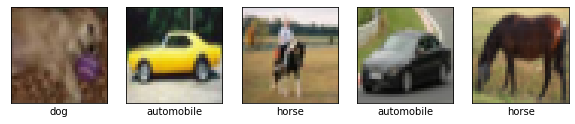

In [6]:
# Take some random examples, reshape to a 32x32 image and plot
from random import randint
fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0,len(Xr))
    # The data is stored in a 3x32x32 format, so we need to transpose it
    axes[i].imshow(Xr[n]/255)
    axes[i].set_xlabel((cifar_classes[int(y[n])]))
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

## Stuff

In [7]:
from tensorflow import keras
from IPython.display import clear_output

# For plotting the learning curve in real time
class TrainingPlot(keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
        self.max_acc = 0
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_accuracy'))
        self.max_acc = max(self.max_acc, logs.get('val_accuracy'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            plt.figure(figsize=(12,4))
            plt.subplot(121)
            plt.title("Training Loss")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss")
            plt.plot(N, self.losses, lw=2, c="b", linestyle="-", label = "train_loss")
            plt.plot(N, self.val_losses, lw=2, c="b", linestyle=":", label = "val_loss")
            plt.legend()
            
            plt.subplot(122)
            plt.plot(N, self.acc, lw=2, c="r", linestyle="-", label = "train_acc")
            plt.plot(N, self.val_acc, lw=2, c="r", linestyle=":", label = "val_acc")
            plt.title("Training Accuracy [Epoch {}, Max Acc {:.4f}]".format(epoch, self.max_acc))
            plt.xlabel("Epoch #")
            plt.ylabel("Accuracy")
            plt.legend()
            
            plt.show()

## Exercise 1: A simple model
* Split the data into 80% training and 20% validation sets
* Normalize the data to [0,1]
* Build a ConvNet with 3 convolutional layers interspersed with MaxPooling layers, and one dense layer.
    * Use at least 32 3x3 filters in the first layer and ReLU activation.
    * Otherwise, make rational design choices or experiment a bit to see what works.
* You should at least get 60% accuracy.
* For training, you can try batch sizes of 64, and 20-50 epochs, but feel free to explore this as well
* Plot and interpret the learning curves. Is the model overfitting? How could you improve it further?

In [8]:
from tensorflow.keras import utils

X_norm = Xr / 255
y_cat = utils.to_categorical(y)

In [9]:
from tensorflow.keras import models, layers

model1 = models.Sequential()
model1.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(32,32,3)))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(64, (3,3), activation='relu', input_shape=(32,32,3)))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Conv2D(128, (3,3), activation='relu', input_shape=(32,32,3)))
model1.add(layers.MaxPooling2D((2,2)))
model1.add(layers.Flatten())
model1.add(layers.Dense(512, activation='relu'))
model1.add(layers.Dense(10, activation='softmax'))
model1.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 30, 30, 32)        896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 13, 13, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0

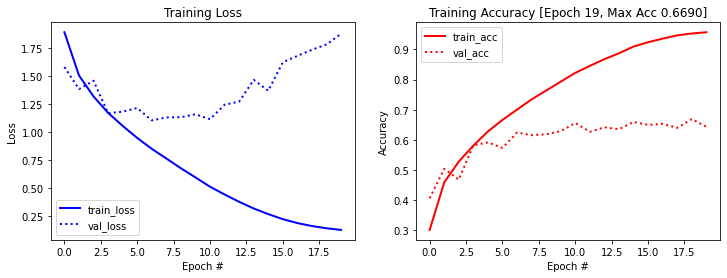

In [10]:
from tensorflow.keras import callbacks

plotter = TrainingPlot()
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=3)
history = model1.fit(X_norm, y_cat, batch_size=64, epochs=20, validation_split=0.2, callbacks=[plotter])

## Exercise 2: VGG-like model
* Implement a simplified VGG model by building 3 'blocks' of 2 convolutional layers each
* Do MaxPooling after each block
* The first block should use at least 32 filters, later blocks should use more
* You can use 3x3 filters
* Use zero-padding to be able to build a deeper model (see the `padding` attribute)
* Use a dense layer with at least 128 hidden nodes.
* You can use ReLU activations everywhere (where it makes sense)
* Plot and interpret the learning curves


In [27]:
from tensorflow.keras import models, layers

model2 = models.Sequential()
model2.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model2.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model2.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))          
model2.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model2.add(layers.MaxPooling2D((2,2)))
model2.add(layers.Flatten())
model2.add(layers.Dense(512, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))
model2.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model2.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_39 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_40 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_41 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_42 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 8, 8, 128)        

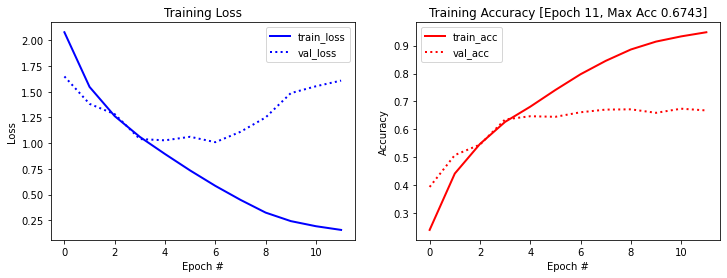

In [28]:
from tensorflow.keras import callbacks

plotter = TrainingPlot()
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model2.fit(X_norm, y_cat, batch_size=64, epochs=20, validation_split=0.2, callbacks=[plotter, earlystop])

## Exercise 3: Regularization
* Explore different ways to regularize your VGG-like model
  * Try adding some dropout after every MaxPooling and Dense layer.
    * What are good Dropout rates? Try a fixed Dropout rate, or increase the rates in the deeper layers.
  * Try batch normalization together with Dropout
    * Think about where batch normalization would make sense 
* Plot and interpret the learning curves


In [31]:
from tensorflow.keras import models, layers

model3 = models.Sequential()
model3.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model3.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model3.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))          
model3.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model3.add(layers.MaxPooling2D((2,2)))
model3.add(layers.Dropout(0.5))
model3.add(layers.Flatten())
model3.add(layers.Dense(512, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))
model3.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model3.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 16, 16, 64)        36928     
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 8, 8, 64)         

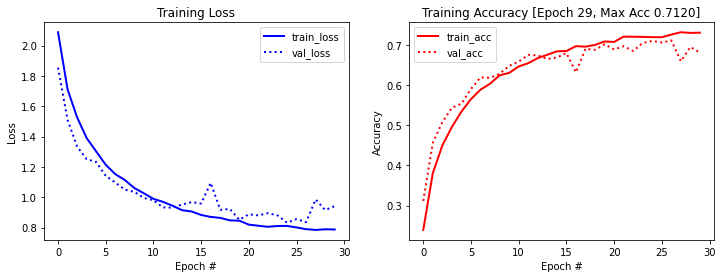

In [32]:
from tensorflow.keras import callbacks

plotter = TrainingPlot()
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=5)
history = model3.fit(X_norm, y_cat, batch_size=64, epochs=50, validation_split=0.2, callbacks=[plotter, earlystop])

**Results**

Adding dropout made the model overfit much less, allowing to train longer and achieve greater accuracy.

In [37]:
from tensorflow.keras import models, layers

model4 = models.Sequential()
model4.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
model4.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.7))
model4.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model4.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.7))
model4.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))          
model4.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
model4.add(layers.MaxPooling2D((2,2)))
model4.add(layers.BatchNormalization())
model4.add(layers.Dropout(0.7))
model4.add(layers.Flatten())
model4.add(layers.Dense(512, activation='relu'))
model4.add(layers.Dense(10, activation='softmax'))
model4.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model4.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_57 (Conv2D)           (None, 32, 32, 32)        896       
_________________________________________________________________
conv2d_58 (Conv2D)           (None, 32, 32, 32)        9248      
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 16, 16, 32)        128       
_________________________________________________________________
dropout_9 (Dropout)          (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_59 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
conv2d_60 (Conv2D)           (None, 16, 16, 64)      

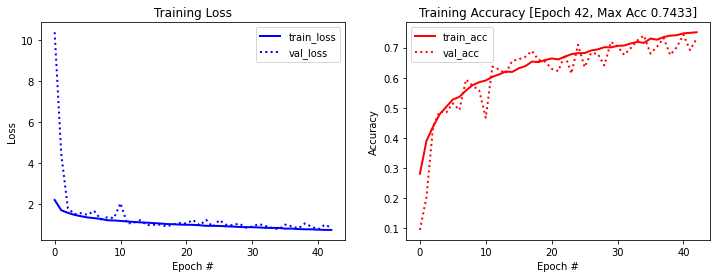

In [38]:
from tensorflow.keras import callbacks

plotter = TrainingPlot()
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=8)
history = model4.fit(X_norm, y_cat, batch_size=64, epochs=50, validation_split=0.2, callbacks=[plotter, earlystop])

**Results**

Adding batch normalization had a small positive effect on accuracy. Increasing dropout rates made accuracy much worse in the beginning, but reduced overfitting so accuracy increased after longer training.

## Exercise 4: Data Augmentation
* Perform image augmentation (rotation, shift, shear, zoom, flip,...). You can use the ImageDataGenerator for this.
* What is the effect? What is the effect with and without Dropout?
* Plot and interpret the learning curves


In [47]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

X_train, X_test, y_train, y_test = train_test_split(X_norm, y_cat, stratify=y_cat, test_size=0.2)

datagen = ImageDataGenerator(
#       rotation_range=40,     # Rotate image up to 40 degrees
      width_shift_range=0.1, # Shift image left-right up to 20% of image width
      height_shift_range=0.1,# Shift image up-down up to 20% of image height
#       shear_range=0.2,       # Shear (slant) the image up to 0.2 degrees
#       zoom_range=0.2,        # Zoom in up to 20%
      horizontal_flip=True,  # Horizontally flip the image
      fill_mode='nearest')

gen_train = datagen.flow(X_train, y_train, batch_size=64)

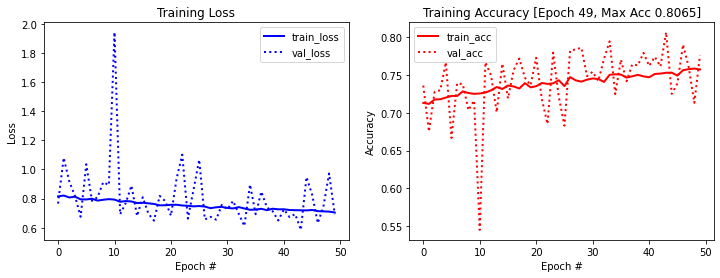

In [49]:
from tensorflow.keras import callbacks

plotter = TrainingPlot()
earlystop = callbacks.EarlyStopping(monitor='val_loss', patience=8)
history = model4.fit(gen_train, epochs=50, validation_data=(X_test, y_test), callbacks=[plotter])

**Results**

Adding data augmentation almost prevented overfitting, but also made the results less predictable, and the training accuracy was also lower. With longer training we could see even more improvement.

## Exercise 5: Interpret the misclassifications
Chances are that even your best model is not yet perfect. It is important to understand what kind of errors it still makes.
* Run the test images through the network and detect all misclassified ones
* Interpret some of the misclassifications. Are these misclassifications to be expected? 
* Compute the confusion matrix. Which classes are often confused?

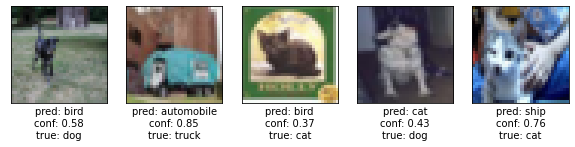

In [66]:
pred_probs = model4.predict(X_test)
preds_cat = []
preds_conf = []
preds_name = []
for pred_prob in pred_probs:
    i = np.argmax(pred_prob)
    preds_cat.append(i)
    preds_conf.append(np.max(pred_prob))
    preds_name.append(cifar_classes[i])
    
true_cat = []
true_name = []
for onehot in y_test:
    i = np.argmax(onehot)
    true_cat.append(i)
    true_name.append(cifar_classes[i])

miss_ids = []
for i in range(len(preds_cat)):
    if preds_cat[i] != true_cat[i]:
        miss_ids.append(i)

fig, axes = plt.subplots(1, 5,  figsize=(10, 5))
for i in range(5):
    n = randint(0, len(miss_ids))
    sample_id = miss_ids[n]
    axes[i].imshow(X_test[sample_id])
    axes[i].set_xlabel(f'pred: {preds_name[sample_id]}\nconf: {preds_conf[sample_id]:.2f}\ntrue: {true_name[sample_id]}')
    axes[i].set_xticks(()), axes[i].set_yticks(())
plt.show();

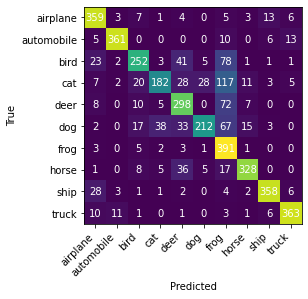

In [67]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(true_cat, preds_cat)
fig, ax = plt.subplots()
im = ax.imshow(cm)
ax.set_xticks(np.arange(10)), ax.set_yticks(np.arange(10))
ax.set_xticklabels(list(cifar_classes.values()), rotation=45, ha="right")
ax.set_yticklabels(list(cifar_classes.values()))
ax.set_ylabel('True')
ax.set_xlabel('Predicted')
for i in range(100):
    ax.text(int(i/10),i%10,cm[i%10,int(i/10)], ha="center", va="center", color="w")

## Exercise 6: Interpret the model
Retrain your best model on all the data. Next, retrieve and visualize the activations (feature maps) for every filter for every convolutional layer, or at least for a few filters for every layer. Tip: see the course notebooks for examples on how to do this. 

Interpret the results. Is your model indeed learning something useful?

## Optional: Take it a step further
* Repeat the exercises, but now use a [higher-resolution version of the CIFAR dataset](https://www.openml.org/d/40926) (with OpenML ID 41103), or another [version with 100 classes](https://www.openml.org/d/41983) (with OpenML ID 41983). Good luck!
